### Seq2Seq 모델 연습

- Seq2Seq란? 인코더 + 디코더로 이루어진 언어 모델로, 입력 text의 시퀀스 수와 출력 text의 시퀀스 수가 다른 경우 사용됨

    * Encoder와 Decoder 모두 같은 수의 셀(hidden unit)이 사용됨
    * Encoder 마지막 cell에서 나온 context vector을 Decoder의 Initial State로 활용(LSTM의 경우 cell state와 h 값을 반환)

- 사용 분야 : Chatbot, 기계 번역


* 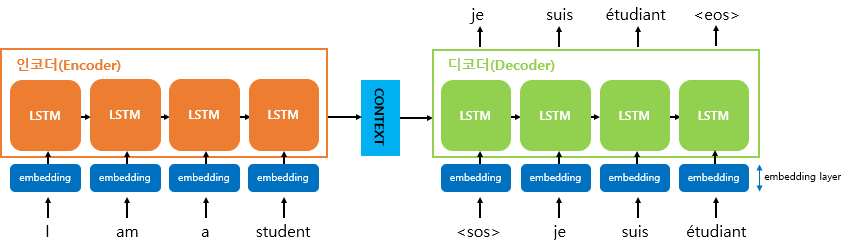

#### Keras 실습

#### 1. Character Level 번역기 만들기

-  데이터셋 : 영어 및 프랑스어 문장 벙렬 코퍼스 활용 (http://www.manythings.org/anki)
    1. Encoder Input
    2. Decoder Input : <sos> 포함된 Decoder training용 input(교사 강요)
    3. Decoder Target : <eos> 포함된 Decoder accuracy 측정을 위한 정답 ouput

- 데이터 전처리
    1. 기존 target data에 시작 토큰 "\t" 및 끝 토큰 "\n"을 추가
    2. Character 단위로 정수 인코딩을 진행하여 Encoder Input을 생성
    3. 동일하게 Character 단위로 정수 인코딩 진행하여 Decoder Input를 생섬 및 시작 토큰 "\t"를 제외한 Decoder Target을 생성

In [ ]:
import os
import shutil
import zipfile
import requests
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import urllib3

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from google.colab import drive
drive.mount('/content/drive')


### 1. 데이터 불러오기
# http://www.manythings.org/anki 내 fra-eng.zip이라는 영어 - 프랑스어 병렬 코퍼스 활용
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

def download_zip(url, output_path):
    response = requests.get(url, headers=headers, stream=True)
    if response.status_code == 200:
        with open(output_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"ZIP file downloaded to {output_path}")
    else:
        print(f"Failed to download. HTTP Response Code: {response.status_code}")

url = "http://www.manythings.org/anki/fra-eng.zip"
output_path = "fra-eng.zip"
download_zip(url, output_path)

path = os.getcwd()
zipfilename = os.path.join(path, output_path)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)

lines = pd.read_csv('fra.txt', names=['src', 'tar', 'lic'], sep='\t')
del lines['lic']

# 데이터 둘러보기
lines.head()

In [ ]:
# 총 데이터 정보 가져오기
# lines.info()

# 60000개의 샘플을 잘라서 train에 활용
train_lines = lines.loc[:60000,:]
train_lines

### 데이터셋 만들기
# 1. Encoder Input
# 2. Decoder Input : 문장 시작 부분에 \t를 추가
# 3. Decoder Target : 문장 마무리 부분에 \n을 추가

train_lines['tar'] = "\t " + train_lines['tar'] + " \n"     # 시작, 끝 부분에 \t, \n 추가
train_lines

# 문자 집합 구축
src_vocab = {char for line in train_lines.src for char in line}     # Encoder 문자 집합(영어)
tar_vocab = {char for line in train_lines.tar for char in line}     # Decoder 문자 집합(프랑스어)

src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))

src_to_index = {i:j+1 for j,i in enumerate(src_vocab)}
tar_to_index = {i:j+1 for j,i in enumerate(tar_vocab)}


# 1. Encoder Input 만들기 : 정수 인코딩 진행
encoder_input = []
for i in train_lines['src']:
  encoder_input.append([src_to_index[j] for j in i])

# 2. Decoder Input 만들기 : 정수 인코딩 진행
decoder_input = []
for i in train_lines['tar']:
  decoder_input.append([tar_to_index[j] for j in i])

# 3. Decoder Target 만들기 : 문장 처음에 붙은 \t 제거 후 정수 인코딩 진행
decoder_target = []
for i in train_lines['tar']:
    i = i.replace("\t","")
    decoder_target.append([tar_to_index[j] for j in i])

decoder_target[:5]

In [ ]:
### 최대 길이로 Padding
max_len_src = max([len(i) for i in train_lines['src']])
max_len_tar = max([len(i) for i in train_lines['tar']])

encoder_input = pad_sequences(encoder_input, maxlen=max_len_src, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_len_tar, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_len_tar, padding='post')

### One-hot Encoding 진행
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

#### Training

- 학습 방법
    1. Encoder을 Encoder Input을 이용해서 학습 진행
    2. Encoder 내 LSTM 셀 중 마지막 출력을 Decoder의 Initial State로 활용
    3. Decoder을 Decoder Input을 활용하여 학습 진행
    4. Decoder의 결과와 Decoder Target 사이의 Cross Entropy Loss로 Backpropagation 진행


#### 1. Keras 활용

1-1 Training

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model


# 매개 변수 목록
hidden_units = 256
src_vocab_size = len(src_vocab) + 1
tar_vocab_size = len(tar_vocab) + 1


# 1. Encoder 학습
encoder_inputs = Input(shape = (None, src_vocab_size))
encoder_lstm = LSTM(units = hidden_units, return_state = True)

encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c] # cell state와 h를 decoder에 전달


# 2. Decoder 학습
decoder_inputs = Input(shape = (None, tar_vocab_size))
decoder_lstm = LSTM(units = hidden_units, return_sequences = True, return_state = True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state = encoder_states)

# Decoder Output을 softmax를 거쳐 출력 형태로 전환
decoder_softmax_layer = Dense(tar_vocab_size, activation = 'softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

# Model 완성
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy')

In [ ]:
# Model 학습 진행
model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size=64, epochs=40, validation_split=0.2)

1-2 추론

In [ ]:
# 1. Encoder : 앞서 학습한 모델의 파라미터를 이용해서 모델을 정의

encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

# 2. Decoder : 앞서 학습한 모델의 파라미터 및 Encoder의 output을 활용하여 모델을 정의

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)     # 추론 시 Decoder 내의 각 셀의 output도 반환받음

decoder_states = [state_h, state_c]
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)

In [ ]:
index_to_src = dict((i, char) for char, i in src_to_index.items())
index_to_tar = dict((i, char) for char, i in tar_to_index.items())

### Decoder의 Output을 활용해서 번역기 완성하기
def decode_sequence(input_seq):

    # 1. input_seq을 input으로 하여 Encoder의 state 반환
    states_value = encoder_model.predict(input_seq)

    # 2. 시작 토큰 (\t)를 one-hot encoding 진행
    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, tar_to_index['\t']] = 1.

    # 3. Decoder의 Output을 정수 인코딩과 비교하여
    stop_condition = False  # Stop Condition이 True가 될때까지 반복
    decoded_sentence = ""

    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
            len(decoded_sentence) > max_len_tar):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, tar_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [ ]:
for seq_index in [3,50,100,300,3001]: # 입력 문장의 인덱스
    input_seq = encoder_input[seq_index:seq_index+1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.src[seq_index])
    print('정답 문장:', lines.tar[seq_index][2:len(lines.tar[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역 문장:', decoded_sentence[1:len(decoded_sentence)-1]) # '\n'을 빼고 출력

#### 2. Torch 활용

2-1 Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Device 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
embed_dim = 128
hidden_units = 256
src_vocab_size = len(src_vocab) + 1
tar_vocab_size = len(tar_vocab) + 1

# 1. Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

# 2. Decoder
class Decoder(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden, cell):
        embedded = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        outputs = self.fc(outputs)
        outputs = F.log_softmax(outputs, dim=-1)
        return outputs, hidden, cell

# 3. Seq2Seq : Encoder & Decoder 활용
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, encoder_input, decoder_input):
        hidden, cell = self.encoder(encoder_input)
        outputs, _, _ = self.decoder(decoder_input, hidden, cell)
        return outputs


encoder = Encoder(input_dim=src_vocab_size, embed_dim=embed_dim, hidden_dim=hidden_units)
decoder = Decoder(output_dim=tar_vocab_size, embed_dim=embed_dim, hidden_dim=hidden_units)

model = Seq2Seq(encoder, decoder).to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

학습 과정에서 에러 발생 -> 원인 파악 필요

In [ ]:
# PyTorch tensor로 변환 진행
encoder_input = torch.tensor(encoder_input, dtype=torch.long).to(device)
decoder_input = torch.tensor(decoder_input, dtype=torch.long).to(device)
decoder_target = torch.tensor(decoder_target, dtype=torch.long).to(device)

# Training 진행
epochs = 40
batch_size = 64
for epoch in range(epochs):
    model.train()
    for i in range(0, len(encoder_input), batch_size):

        # Prepare batch
        encoder_batch = encoder_input[i:i+batch_size]
        decoder_batch = decoder_input[i:i+batch_size]
        target_batch = decoder_target[i:i+batch_size]

        optimizer.zero_grad()
        output = model(encoder_batch, decoder_batch)

        loss = criterion(output.view(-1, tar_vocab_size), target_batch.view(-1))
        loss.backward()

        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

#### 2. Word Level 번역기 만들기

-  데이터셋 : 영어 및 프랑스어 문장 벙렬 코퍼스 활용 (http://www.manythings.org/anki)
    1. Encoder Input
    2. Decoder Input : <sos> 포함된 Decoder training용 input(교사 강요)
    3. Decoder Target : <eos> 포함된 Decoder accuracy 측정을 위한 정답 ouput

- 데이터 전처리
    1. 프랑스어 코퍼스의 악센트 및 영어 외 문자 제거
    2. 기존 target data에 시작 토큰 "\<sos>" 및 끝 토큰 "\<eos>"을 추가한 뒤 띄어쓰기를 기준으로 split
    3. 띄어쓰기된 Word 단위로 정수 인코딩을 진행하여 Encoder Input을 생성
    4. 동일하게 띄어쓰기된 Word 단위로 정수 인코딩 진행하여 Decoder Input를 생섬 및 시작 토큰 "\<eos>"를 제외한 Decoder Target을 생성

In [ ]:
### 전처리 진행
import re
import unicodedata

# 프랑스어 악센트(accent) 삭제
def to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

# 텍스트 종합 전처리 함수
def preprocess_sentence(sent):

  sent = to_ascii(sent.lower())
  sent = re.sub(r"([?.!,¿])", r" \1", sent)

  # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환.
  sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

  # 다수 개의 공백을 하나의 공백으로 치환
  sent = re.sub(r"\s+", " ", sent)
  return sent


# 데이터셋 전처리 함수 : Encoder Input, Decoder Input, Decoder Target 반환
def load_preprocessed_data():
  encoder_input, decoder_input, decoder_target = [], [], []

  with open("fra.txt", "r") as lines:
    for i, line in enumerate(lines):

      src_line, tar_line, _ = line.strip().split('\t')

      # source 데이터 전처리
      src_line = [w for w in preprocess_sentence(src_line).split()]

      # target 데이터 전처리
      tar_line = preprocess_sentence(tar_line)
      tar_line_in = [w for w in ("<sos> " + tar_line).split()]
      tar_line_out = [w for w in (tar_line + " <eos>").split()]

      encoder_input.append(src_line)
      decoder_input.append(tar_line_in)
      decoder_target.append(tar_line_out)

      if i == num_samples - 1:
        break

  return encoder_input, decoder_input, decoder_target


# 전처리 진행
num_samples = 33000

sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print('인코더의 입력 :',sents_en_in[:5])
print('디코더의 입력 :',sents_fra_in[:5])
print('디코더의 레이블 :',sents_fra_out[:5])

In [ ]:
# 영어 단어 토큰화
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)
encoder_input = pad_sequences(encoder_input, padding="post")

# 프랑스어 단어 토큰화
tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)

decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_input = pad_sequences(decoder_input, padding="post")

decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)
decoder_target = pad_sequences(decoder_target, padding="post")


print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

# 단어 및 단어의 정수 인덱싱 결과 저장
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word
tar_to_index = tokenizer_fra.word_index
index_to_tar = tokenizer_fra.index_word


# Train, Validation Split 진행
from sklearn.model_selection import train_test_split

val_ratio = 0.1

encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test, decoder_target_train, decoder_target_test = train_test_split(
    encoder_input, decoder_input, decoder_target, test_size=val_ratio, random_state=42
)

#### Training

- 학습 방법
    1. Encoder을 Encoder Input을 이용해서 학습 진행
    2. Encoder 내 LSTM 셀 중 마지막 출력을 Decoder의 Initial State로 활용
    3. Decoder을 Decoder Input을 활용하여 학습 진행
    4. Decoder의 결과와 Decoder Target 사이의 Cross Entropy Loss로 Backpropagation 진행

#### 1. Keras 활용

1-1 Training

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

# 매개변수 목록
embedding_dim = 64
hidden_units = 64

# 1. Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs)

# Masking - 패딩 0은 연산에서 제외
enc_masking = Masking(mask_value=0.0)(enc_emb)

encoder_lstm = LSTM(hidden_units, return_state=True)

# Output 반환
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]


# 2. Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units)

# Masking - 패딩 0은 연산에서 제외
dec_emb = dec_emb_layer(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)

decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# Decoder Output을 softmax를 거쳐 출력 형태로 전환
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Model 및 Optimizer 정의
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

1-2 추론

In [ ]:
# 1. Encoder : 앞서 학습한 모델의 파라미터를 이용해서 모델을 정의

encoder_model = Model(encoder_inputs, encoder_states)

# 2. Decoder : 앞서 학습한 모델의 파라미터 및 Encoder의 output을 활용하여 모델을 정의

decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 시 사용했던 Embedding 활용
dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)     # 추론 시 Decoder 내의 각 셀의 output도 반환받음

decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs2] + decoder_states2)

In [ ]:
### Decoder의 Output을 활용해서 번역기 완성하기

def decode_sequence(input_seq):

  states_value = encoder_model.predict(input_seq)

  # 시작 토큰(<SOS>)에 해당하는 정수 인코딩 tensor 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tar_to_index['<sos>']

  stop_condition = False
  decoded_sentence = ''

  while not stop_condition:

    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # argmax를 통해 예측된 단어 인코딩 -> 문자 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    decoded_sentence += ' '+sampled_char

    # 끝 토큰(<eos>)에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '<eos>' or
        len(decoded_sentence) > 50):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence


# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [ ]:
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)